=== Statistik Deskriptif Data ===
count    56.000000
mean      1.482143
std       1.361698
min       0.000000
25%       0.000000
50%       1.000000
75%       2.000000
max       5.000000
Name: y, dtype: float64


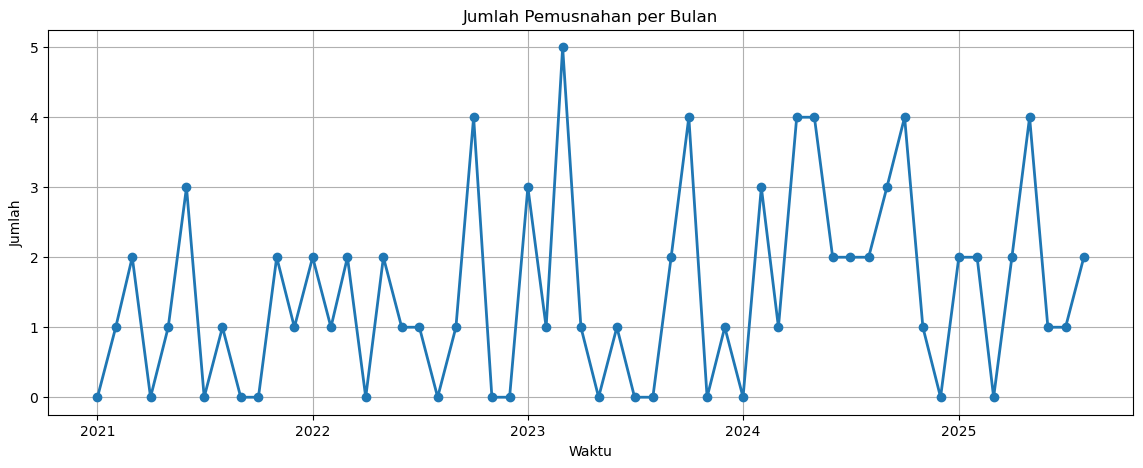

In [2]:
#LOAD DATA
import pandas as pd
import numpy as np

df = pd.read_excel(
    r"C:\Users\IIN FEBYANTI\Magang Mandiri\Project magang\data pemusnahan 2021-2025.xlsx"
)
df = df.rename(columns={'waktu': 'ds', 'jumlah': 'y'})
df['ds'] = pd.to_datetime(df['ds'])
df = df.set_index('ds').asfreq('MS')
df['y'] = df['y'].fillna(0)

#STATISTIK DESKRIPTIF DATA
print("=== Statistik Deskriptif Data ===")
print(df['y'].describe())

# TIME SERIES AWAL
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(df.index, df['y'], marker='o', linewidth=2)
plt.title("Jumlah Pemusnahan per Bulan")
plt.xlabel("Waktu")
plt.ylabel("Jumlah")
plt.grid(True)
plt.show()


# SARIMA

=== Cek Missing Value ===
y    0
dtype: int64


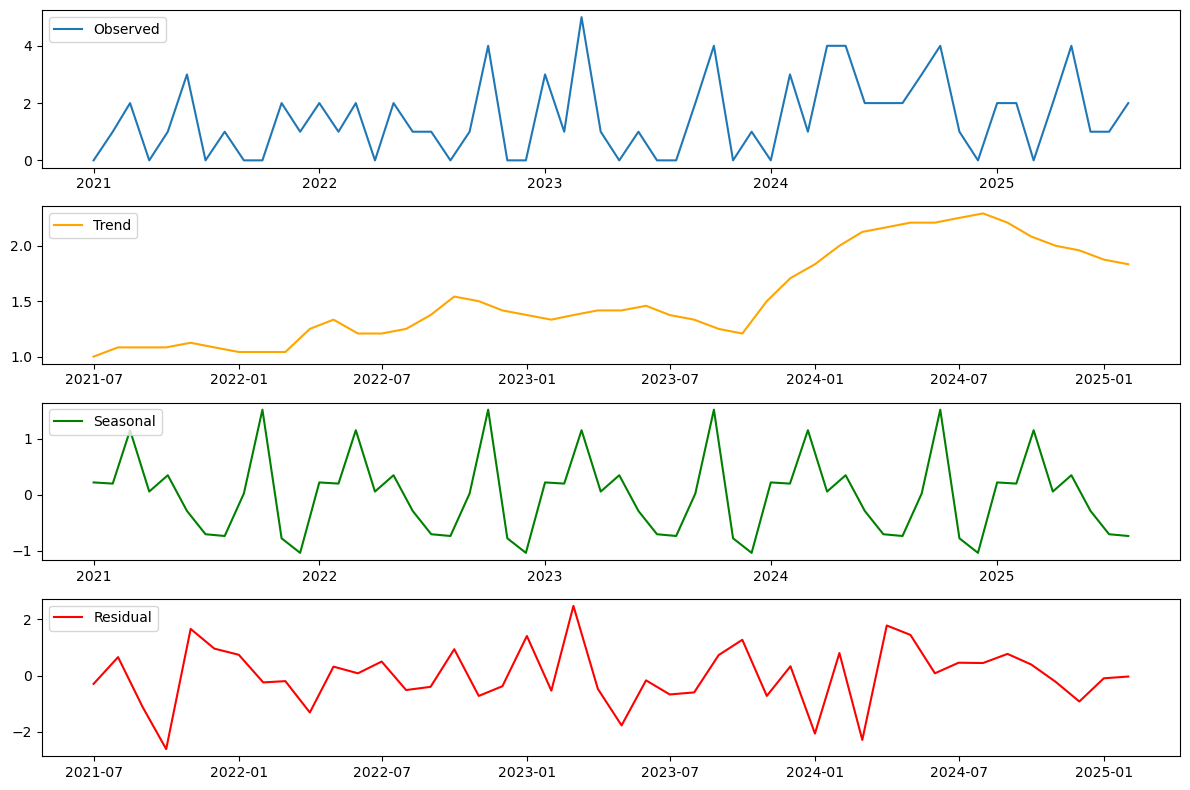


=== UJI Stasioner ADF ===
ADF Statistic : -7.4413
p-value       : 0.0000
Kesimpulan   : Data stasioner (tolak H0)


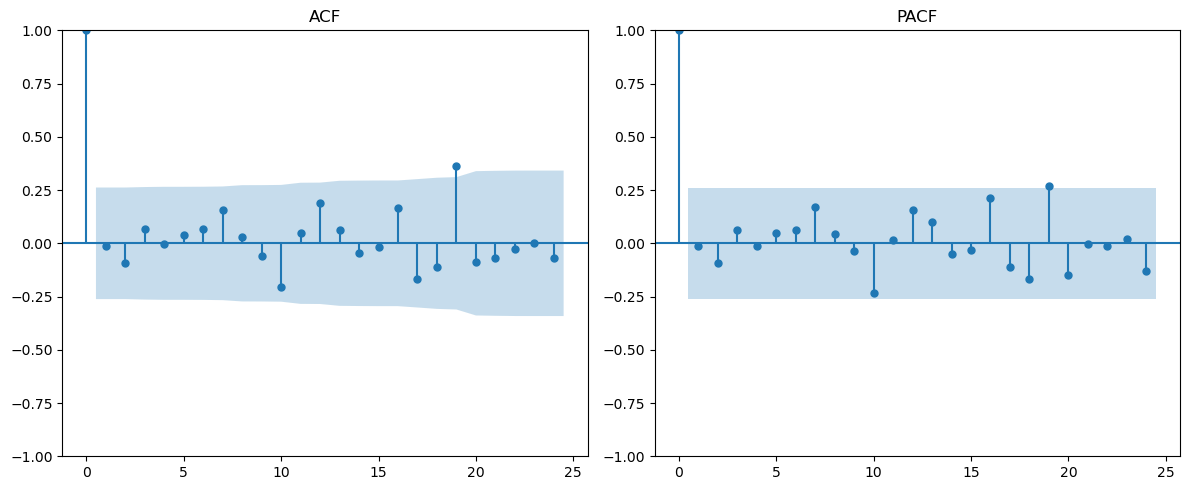


=== Summary SARIMAX Train (2,0,2)(0,1,1,12) ===
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                   44
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 12)   Log Likelihood                 -33.500
Date:                              Thu, 01 Jan 2026   AIC                             79.001
Time:                                      18:51:29   BIC                             84.000
Sample:                                  01-01-2021   HQIC                            79.498
                                       - 08-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8326      0.214     -3.888      

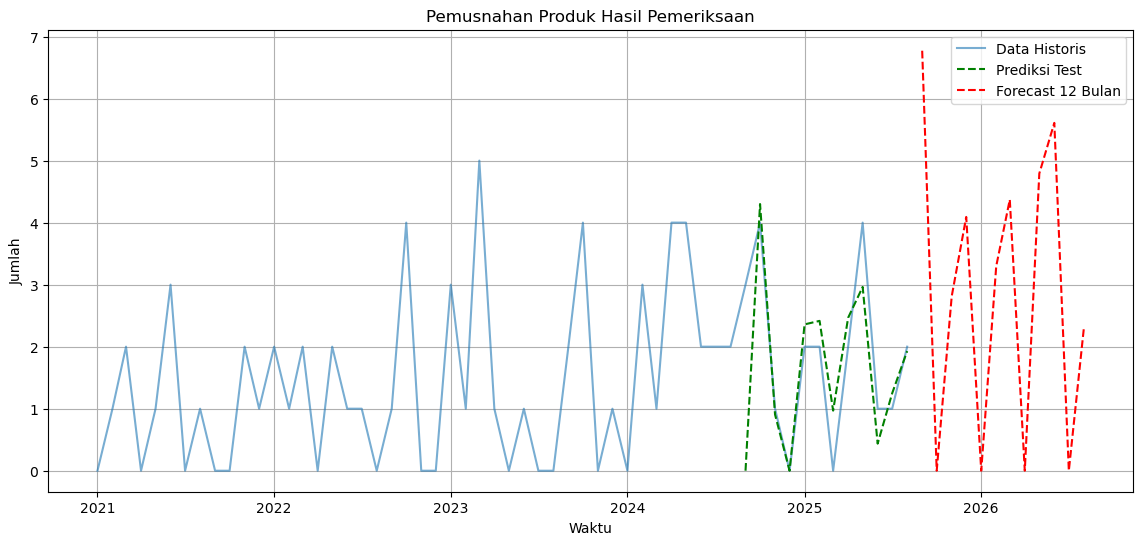

In [3]:
# LOAD DATA 
import pandas as pd
import numpy as np

df = pd.read_excel(
    r"C:\Users\IIN FEBYANTI\Magang Mandiri\Project magang\data pemusnahan 2021-2025.xlsx"
)
df = df.rename(columns={'waktu': 'ds', 'jumlah': 'y'})
df['ds'] = pd.to_datetime(df['ds'])
df = df.set_index('ds').asfreq('MS')
df['y'] = df['y'].fillna(0)

# CEK MISSING VALUE
missing_count = df.isna().sum()
print("=== Cek Missing Value ===")
print(missing_count)

# DEKOMPOSISI TIME SERIES
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(df['y'], model='additive', period=12)
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(decomp.observed, label='Observed')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomp.trend, label='Trend', color='orange')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomp.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomp.resid, label='Residual', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# UJI STASIONERITAS (ADF)
from statsmodels.tsa.stattools import adfuller

print("\n=== UJI Stasioner ADF ===")
adf_result = adfuller(df['y'])
print(f"ADF Statistic : {adf_result[0]:.4f}")
print(f"p-value       : {adf_result[1]:.4f}")
if adf_result[1] < 0.05:
    print("Kesimpulan   : Data stasioner (tolak H0)")
else:
    print("Kesimpulan   : Data tidak stasioner (gagal tolak H0)")

# ACF & PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,5))
plt.subplot(121)
plot_acf(df['y'], lags=min(24, len(df)//2-1), ax=plt.gca())
plt.title("ACF")

plt.subplot(122)
plot_pacf(df['y'], lags=min(24, len(df)//2-1), ax=plt.gca(), method='ywm')
plt.title("PACF")

plt.tight_layout()
plt.show()

# TRAIN–TEST SPLIT
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size].copy()
test  = df.iloc[train_size:].copy()

# FIT MODEL SARIMAX PADA TRAIN
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

order = (2, 0, 2)
seasonal_order = (0, 1, 1, 12)

train_model = sm.tsa.statespace.SARIMAX(
    train['y'],
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
train_results = train_model.fit(disp=False)
print("\n=== Summary SARIMAX Train (2,0,2)(0,1,1,12) ===")
print(train_results.summary())

# PREDIKSI TEST
from sklearn.metrics import mean_absolute_error, mean_squared_error

pred_test = train_results.get_prediction(
    start=test.index[0],
    end=test.index[-1]
)
pred_mean = pred_test.predicted_mean.clip(lower=0)

mae = mean_absolute_error(test['y'], pred_mean)
rmse = np.sqrt(mean_squared_error(test['y'], pred_mean))
mask = test['y'] > 0
mape = np.mean(np.abs((pred_mean[mask] - test['y'][mask]) / test['y'][mask])) * 100

print("\n=== Evaluasi Model pada Data Test ===")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"MAPE : {mape:.2f}%")

# FIT MODEL SARIMAX PADA SELURUH DATA (TRAIN + TEST)
full_model = sm.tsa.statespace.SARIMAX(
    df['y'],
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
full_results = full_model.fit(disp=False)

# FORECAST 12 BULAN KE DEPAN (SETELAH TEST)
forecast_res = full_results.get_forecast(steps=12)
forecast_mean = forecast_res.predicted_mean.clip(lower=0)

future_dates = pd.date_range(
    start=df.index[-1] + pd.DateOffset(months=1),
    periods=12,
    freq='MS'
)
forecast_df = pd.DataFrame({'yhat': forecast_mean.values}, index=future_dates)

# TABEL PERBANDINGAN
# Prediksi test
comparison_test_df = pd.DataFrame({
    'Tanggal': test.index,
    'Data Sebenarnya': test['y'],
    'Prediksi Data Uji': pred_mean
})

# Forecast 12 bulan
forecast_df_reset = forecast_df.reset_index()
forecast_df_reset.rename(columns={'index':'Tanggal','yhat':'Prediksi 2025'}, inplace=True)

print("\n=== Tabel Prediksi Test ===")
print(comparison_test_df)

print("\n=== Tabel Forecast 2025 ===")
print(forecast_df_reset)

# VISUALISASI
plt.figure(figsize=(14,6))
plt.plot(df.index, df['y'], alpha=0.6, label='Data Historis')
plt.plot(test.index, pred_mean, '--', color='green', label='Prediksi Test')
plt.plot(forecast_df.index, forecast_df['yhat'], 'r--', label='Forecast 12 Bulan')
plt.title("Pemusnahan Produk Hasil Pemeriksaan")
plt.xlabel("Waktu")
plt.ylabel("Jumlah")
plt.legend()
plt.grid(True)
plt.show()

# Holt - Winters Exponential Smoothing


=== Summary ETS Multiplikatif ===
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    y_trf   No. Observations:                   44
Model:             ExponentialSmoothing   SSE                             57.417
Optimized:                         True   AIC                             43.710
Trend:                         Additive   BIC                             72.257
Seasonal:                Multiplicative   AICC                            71.070
Seasonal Periods:                    12   Date:                 Thu, 01 Jan 2026
Box-Cox:                          False   Time:                         18:51:32
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0500364                alpha            

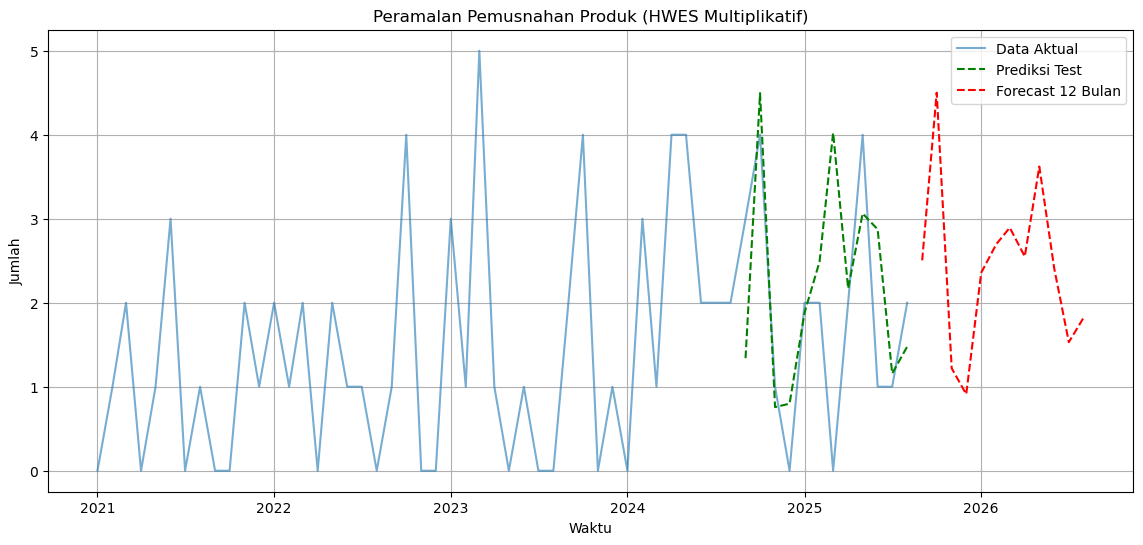

In [4]:
# LOAD DATA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

df = pd.read_excel(
    r"C:\Users\IIN FEBYANTI\Magang Mandiri\Project magang\data pemusnahan 2021-2025.xlsx"
)

df = df.rename(columns={'waktu': 'ds', 'jumlah': 'y'})
df['ds'] = pd.to_datetime(df['ds'])
df = df.set_index('ds').asfreq('MS')

#CEK MISSING VALUE
missing_count = df.isna().sum()

# TRANSFORMASI DATA
df['y_trf'] = df['y'] + 1   

# TRAIN - TEST SPLIT
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test  = df.iloc[train_size:]

# FIT MODEL HOLT-WINTERS MULTIPLIKATIF
ets_model = ExponentialSmoothing(
    train['y_trf'],
    trend='add',
    seasonal='mul',
    seasonal_periods=12
)
ets_fit = ets_model.fit(optimized=True)

print("\n=== Summary ETS Multiplikatif ===")
print(ets_fit.summary())

# PREDIKSI DATA TEST
pred_test_trf = ets_fit.forecast(steps=len(test))
pred_test = (pred_test_trf - 1).clip(lower=0)

# Evaluasi
mae  = mean_absolute_error(test['y'], pred_test)
rmse = np.sqrt(mean_squared_error(test['y'], pred_test))
mask = test['y'] > 0
mape = np.mean(np.abs((pred_test[mask] - test['y'][mask]) / test['y'][mask])) * 100

print("\n=== Evaluasi Model Test ===")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"MAPE : {mape:.2f}%")

# FIT MODEL PADA SELURUH DATA
full_ets = ExponentialSmoothing(
    df['y_trf'],
    trend='add',
    seasonal='mul',
    seasonal_periods=12
).fit(optimized=True)

# FORECAST 12 BULAN KE DEPAN
forecast_trf = full_ets.forecast(steps=12)
forecast = (forecast_trf - 1).clip(lower=0)

future_dates = pd.date_range(
    start=df.index[-1] + pd.DateOffset(months=1),
    periods=12,
    freq='MS'
)

forecast_df = pd.DataFrame({'Prediksi 2025': forecast.values}, index=future_dates)

# Tabel prediksi test
comparison_test_df = pd.DataFrame({
    'Tanggal': test.index,
    'Data Sebenarnya': test['y'],
    'Prediksi Test': pred_test.values
})

print("\n=== Tabel Prediksi Test ===")
print(comparison_test_df)

print("\n=== Tabel Forecast 2025 ===")
print(forecast_df.reset_index().rename(columns={'index':'Tanggal'}))

# VISUALISASI
plt.figure(figsize=(14,6))
plt.plot(df.index, df['y'], label='Data Aktual', alpha=0.6)
plt.plot(test.index, pred_test, '--', label='Prediksi Test', color='green')
plt.plot(forecast_df.index, forecast_df['Prediksi 2025'], 'r--', label='Forecast 12 Bulan')
plt.title("Peramalan Pemusnahan Produk (HWES Multiplikatif)")
plt.xlabel("Waktu")
plt.ylabel("Jumlah")
plt.legend()
plt.grid(True)
plt.show()

# GLM Poisson


Summary Poisson GLM
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   44
Model:                            GLM   Df Residuals:                       31
Model Family:                 Poisson   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -60.954
Date:                Thu, 01 Jan 2026   Deviance:                       46.866
Time:                        18:51:37   Pearson chi2:                     38.1
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3427
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2889      0.50

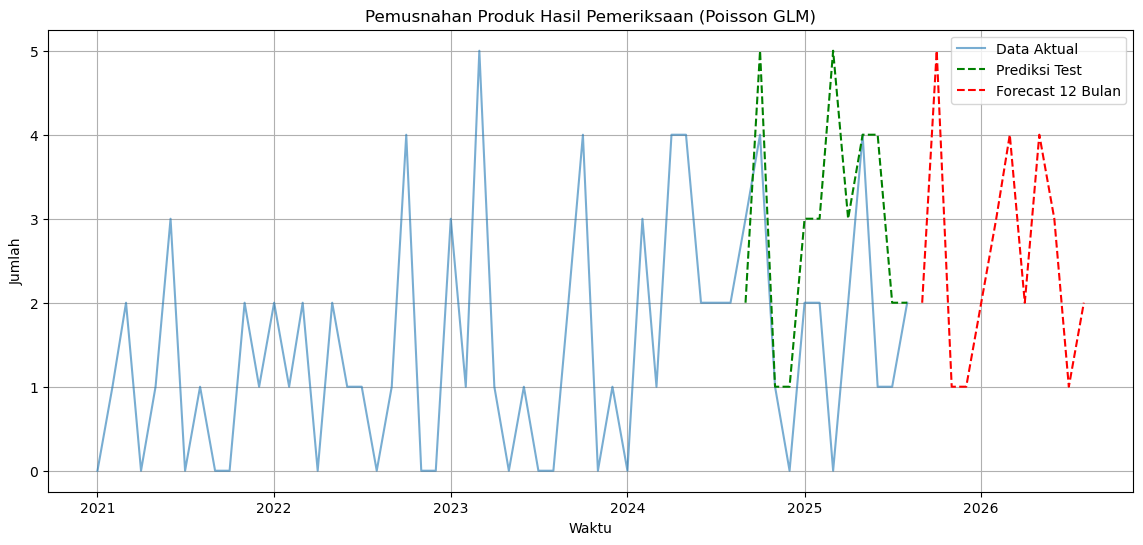

In [5]:
#LOAD DATA
import pandas as pd
df = pd.read_excel(
    r"C:\Users\IIN FEBYANTI\Magang Mandiri\Project magang\data pemusnahan 2021-2025.xlsx"
)

df = df.rename(columns={'waktu': 'ds', 'jumlah': 'y'})
df['ds'] = pd.to_datetime(df['ds'])
df = df.set_index('ds').asfreq('MS')

#CEK MISSING VALUE
missing_count = df.isna().sum()

# FEATURE ENGINEERING 
import numpy as np
df['time_index'] = np.arange(len(df))
df['month'] = df.index.month

# membuat dummy bulan
month_dummies = pd.get_dummies(df['month'], prefix='month', drop_first=True).astype(int)

df_model = pd.concat([df[['y', 'time_index']], month_dummies], axis=1)

# TRAIN–TEST SPLIT
train_size = int(len(df_model) * 0.8)
train = df_model.iloc[:train_size]
test  = df_model.iloc[train_size:]

# FIT MODEL POISSON GLM (TRAIN)
import statsmodels.api as sm
X_train = train.drop(columns='y').astype(float)
y_train = train['y'].astype(float)

X_train = sm.add_constant(X_train)

poisson_model = sm.GLM(
    y_train,
    X_train,
    family=sm.families.Poisson()
)

poisson_fit = poisson_model.fit()
print("\nSummary Poisson GLM")
print(poisson_fit.summary())

# PREDIKSI DATA TEST
X_test = test.drop(columns='y').astype(float)
X_test = sm.add_constant(X_test)

pred_test = poisson_fit.predict(X_test)
pred_test = np.round(pred_test).clip(lower=0)

# EVALUASI MODEL
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae  = mean_absolute_error(test['y'], pred_test)
rmse = np.sqrt(mean_squared_error(test['y'], pred_test))
mask = test['y'] > 0
mape = np.mean(np.abs((pred_test[mask] - test['y'][mask]) / test['y'][mask])) * 100

print("\nEvaluasi Model Poisson GLM")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"MAPE : {mape:.2f}%")

# FIT MODEL PADA SELURUH DATA
import statsmodels.api as sm
X_full = df_model.drop(columns='y').astype(float)
y_full = df_model['y'].astype(float)
X_full = sm.add_constant(X_full)

full_model = sm.GLM(
    y_full,
    X_full,
    family=sm.families.Poisson()
).fit()

# FORECAST 12 BULAN KE DEPAN
future_dates = pd.date_range(
    start=df.index[-1] + pd.DateOffset(months=1),
    periods=12,
    freq='MS'
)

future_df = pd.DataFrame(index=future_dates)
future_df['time_index'] = np.arange(len(df), len(df) + 12)
future_df['month'] = future_df.index.month

future_month_dummies = pd.get_dummies(future_df['month'], prefix='month', drop_first=True).astype(int)
future_X = pd.concat([future_df[['time_index']], future_month_dummies], axis=1)

future_X = future_X.reindex(columns=X_full.columns.drop('const'), fill_value=0)
future_X = sm.add_constant(future_X)

forecast = full_model.predict(future_X)
forecast = np.round(forecast).clip(lower=0)

forecast_df = pd.DataFrame({'yhat': forecast.values}, index=future_dates)

comparison_test_df = pd.DataFrame({
    'Tanggal': test.index,
    'Data Sebenarnya': test['y'],
    'Prediksi Test': pred_test.values
})

print("\n=== Tabel Prediksi Test ===")
print(comparison_test_df)

print("\n=== Tabel Forecast 2025 ===")
print(forecast_df.reset_index().rename(columns={'index':'Tanggal'}))

# VISUALISASI
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
plt.plot(df.index, df['y'], alpha=0.6, label='Data Aktual')
plt.plot(test.index, pred_test, '--', color='green', label='Prediksi Test')
plt.plot(forecast_df.index, forecast_df['yhat'], 'r--', label='Forecast 12 Bulan')
plt.title("Pemusnahan Produk Hasil Pemeriksaan (Poisson GLM)")
plt.xlabel("Waktu")
plt.ylabel("Jumlah")
plt.legend()
plt.grid(True)
plt.show()